In [ ]:
import numpy as np
import pandas as pd

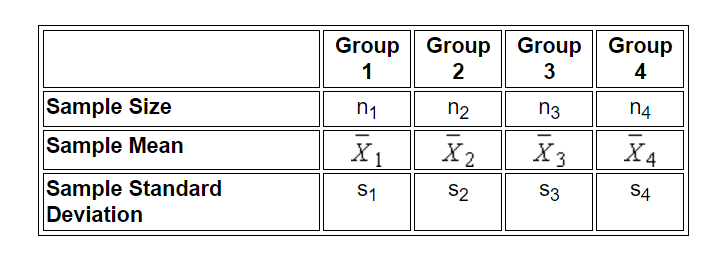
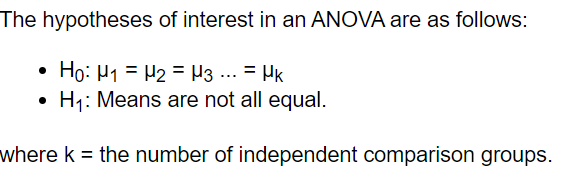
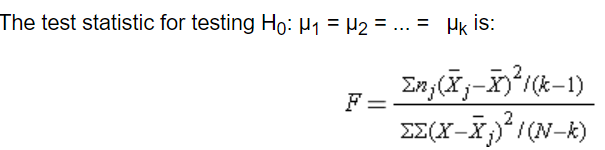

Here, there are __four treatments (A, B, C, and D)__, which are __groups__ for __ANOVA analysis__. Treatments are __independent variable__ and termed as __factor__. As there are four types of treatments, treatment factor has __four levels__.

In [ ]:
data = {'A': [25,30,28,36,29], 
        'B': [45,55,29,56,40],
        'C': [30,29,33,37,27],
        'D': [54,60,51,62,73]}
data = pd.DataFrame(data=data)
data

In [ ]:
# reshape the d dataframe suitable for statsmodels package 
data_melt = pd.melt(data.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])

In [ ]:
data_melt

In [ ]:
# replace column names
data_melt.columns = ['index', 'treatments', 'value']
data_melt

In [ ]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='treatments', y='value', data=data_melt, color='#99c2a2')
ax = sns.swarmplot(x="treatments", y="value", data=data_melt, color='#7d0013')
plt.show()

Now, perform __one-way ANOVA__

In [ ]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(data['A'], data['B'], data['C'], data['D'])
print(fvalue, pvalue)

How would you interpret this?

In [ ]:
# get ANOVA table as output
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ treatments', data=data_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

The **p-value obtained from ANOVA analysis is significant (p < 0.05)**, and therefore, we conclude that there are **significant differences among treatments**.


From ANOVA analysis, we know that treatment differences are statistically significant, but **ANOVA does not tell which treatments are significantly different** from each other. 

To know the pairs of significant different treatments, we will perform **multiple pairwise comparison (post hoc comparison)** analysis for all unplanned comparison using **Tukey’s honestly significantly differenced (HSD) test**.

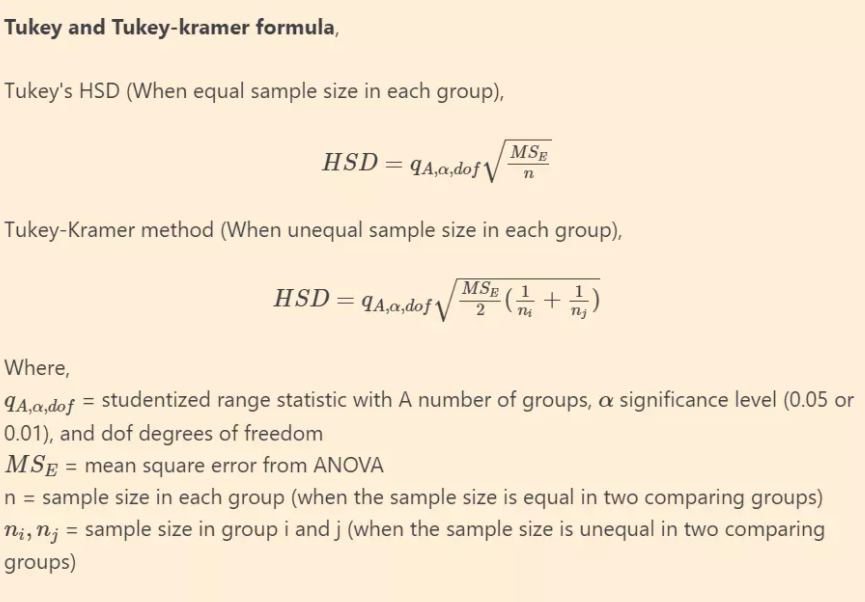

use **bioinfokit** for performing **Tukey HSD test**

In [ ]:
pip install bioinfokit

In [ ]:
from bioinfokit.analys import stat

In [ ]:
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=data_melt, res_var='value', xfac_var='treatments', anova_model='value ~ treatments')
res.tukey_summary

p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

Above results from Tukey’s HSD suggests that **except A-C**, **all other pairwise comparisons for treatments rejects null hypothesis (p < 0.05)** and indicates statistical significant differences.

#### Test ANOVA assumptions
ANOVA assumptions can be checked using test statistics (e.g. **Shapiro-Wilk**) and the visual approaches such as residual plots (e.g. **QQ-plots**) and histograms.

**The visual approaches perform better than statistical tests**. For example, the **Shapiro-Wilk test** has **low power for small sample size** data and **deviates significantly from normality for large sample sizes (say n > 50)**. For large sample sizes, you should consider to use QQ-plot for normality assumption.

In [ ]:
# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

In [ ]:
# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [ ]:
import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

As the p value is non significant, we fail to reject null hypothesis and conclude that data is drawn from normal distribution.

As the data is drawn from normal distribution, use **Bartlett’s test to check the homogeneity of variances**. 

Null hypothesis: samples from populations have equal variances.

In [ ]:
import scipy.stats as stats
w, pvalue = stats.bartlett(data['A'], data['B'], data['C'], data['D'])
print(w, pvalue)

As the p value (0.13) is non significant, we fail to reject null hypothesis and conclude that treatments have equal variances.

**Levene’s test can be used to check the homogeneity of variances when the data is NOT drawn from normal distribution**.

In [ ]:
from bioinfokit.analys import stat 
res = stat()
res.levene(df=data_melt, res_var='value', xfac_var='treatments')
res.levene_summary

#### Two-way (two factor) ANOVA (factorial design) with Python

Here, I will discuss the two-way independent ANOVA.

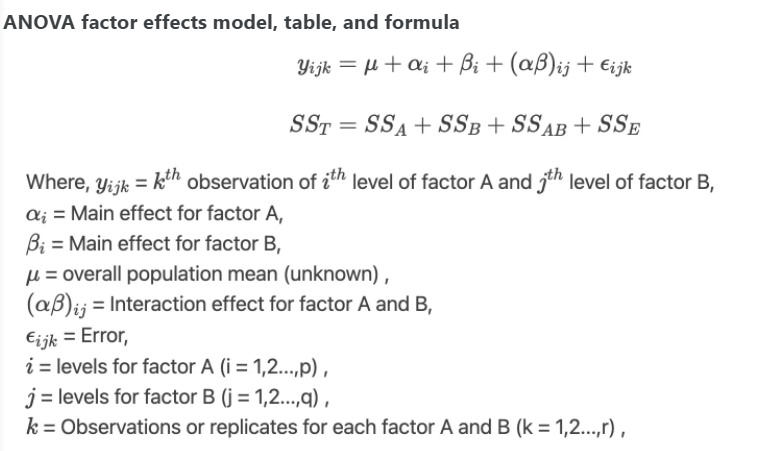

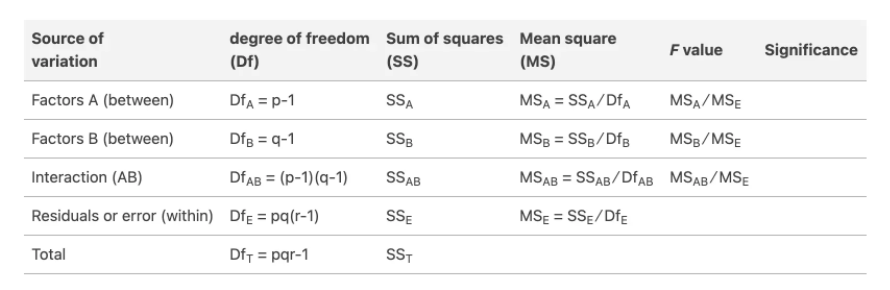

In [ ]:
# import two-way ANOVA data
d = pd.read_csv("C:\\Users\\Eugenio_Py\\Desktop\\Notebooks\\datasets\\two_way_anova_data.txt", sep="\t")
d

In [ ]:
# reshape the d dataframe suitable for statsmodels package 
d_melt = pd.melt(d, id_vars=['Genotype'], value_vars=['1_year', '2_year', '3_year'])
d_melt

In [ ]:
# replace column names
d_melt.columns = ['Genotype', 'years', 'value']
d_melt.head()

In [ ]:
# generate a boxplot to see the data distribution by genotypes and years. 
#Using boxplot, we can easily detect the differences between different groups
sns.boxplot(x="Genotype", y="value", hue="years", data=d_melt, palette="Set3");

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('value ~ C(Genotype) + C(years) + C(Genotype):C(years)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

In [ ]:
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=d_melt, res_var='value', anova_model='value~ Genotype + years + Genotype:years')
res.anova_summary

**The p-value obtained from ANOVA analysis for genotype, years, and interaction are statistically significant (p < 0.05)**. We conclude that type of genotype significantly affects the yield outcome, time (years) significantly affects the yield outcome, and interaction of both genotype and time (years) significantly affects the yield outcome.

As the interaction is significant, let’s visualize the interaction plot (also called profile plot) for interaction effects:

In [ ]:
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig = interaction_plot(x=d_melt['Genotype'], trace=d_melt['years'], response=d_melt['value'], 
    colors=['#4c061d','#d17a22', '#b4c292'])
plt.show();

 - The interaction plot helps to visualize the means of the response of the two factors (Genotype and years) on one graph. Generally, the X-axis should have a factor with more levels.
 
 
 - From the interaction plot, **the interaction effect is significant between the Genotype and years because three lines are not parallel** (roughly parallel factor lines indicate no interaction - additive model). This interaction is also called **ordinal interaction** as the lines do not cross each other.

#### Multiple pairwise comparisons (Post-hoc test)

Now, we know that genotype and time (years) differences are statistically significant, but ANOVA does not tell which genotype and time (years) are significantly different from each other. 

To know the pairs of significant different genotype and time (years), perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey’s HSD test.

In [ ]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()

In [ ]:
# for main effect Genotype
res.tukey_hsd(df=d_melt, res_var='value', xfac_var='Genotype', anova_model='value ~ Genotype + years + Genotype:years')
res.tukey_summary

Note: p-value 0.001 from tukey_hsd output should be interpreted as <=0.001

In [ ]:
# for main effect Genotype
res.tukey_hsd(df=d_melt, res_var='value', xfac_var='Genotype', anova_model='value~C(Genotype)+C(years)+C(Genotype):C(years)')
res.tukey_summary

In [ ]:
# for main effect years
res.tukey_hsd(df=d_melt, res_var='value', xfac_var='years', anova_model='value ~ C(Genotype) + C(years) + C(Genotype):C(years)')
res.tukey_summary

In [ ]:
# for interaction effect between genotype and years - it takes a while
res.tukey_hsd(df=d_melt, res_var='value', xfac_var=['Genotype','years'], anova_model='value ~ C(Genotype) + C(years) + C(Genotype):C(years)')
res.tukey_summary.head()

#### Test ANOVA assumptions
Similar to one-way ANOVA, you can use visual approaches, Bartlett’s or Levene’s, and Shapiro-Wilk test to validate the assumptions for homogeneity of variances and normal distribution of residuals.

In [ ]:
# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from two-way ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

In [ ]:
# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Shapiro-Wilk test
import scipy.stats as stats
w, pvalue = stats.shapiro(res.anova_model_out.resid)
print(w, pvalue)

In [ ]:
from bioinfokit.analys import stat 
res = stat()
res.levene(df=d_melt, res_var='value', xfac_var=['Genotype', 'years'])
res.levene_summary

### Testing Linear Regression Assumptions in Python

For our real-world dataset, we’ll use the **Boston house prices dataset from the late 1970’s**. The toy dataset will be created using `scikit-learn’s make_regression` function which creates a dataset that should perfectly satisfy all of our assumptions.

Here are the variable descriptions for the Boston housing dataset straight from the documentation:

 - __CRIM__: Per capita crime rate by town

 - __ZN__: Proportion of residential land zoned for lots over 25,000 sq.ft.

 - __INDUS__: Proportion of non-retail business acres per town.

 - __CHAS__: Charles River dummy variable (1 if tract bounds river; 0 otherwise)

 - __NOX__: Nitric oxides concentration (parts per 10 million)

 - __RM__: Average number of rooms per dwelling

 - __AGE__: Proportion of owner-occupied units built prior to 1940

 - __DIS__: Weighted distances to five Boston employment centers

 - __RAD__: Index of accessibility to radial highways

 - __TAX__: Full-value property-tax rate per 10,000 USD

 - __PTRATIO__: Pupil-teacher ratio by town
 
 - __LSTAT__: % lower status of the population

 - __MEDV__: Median value of owner-occupied homes in 1,000’s USD

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
%matplotlib inline

In [ ]:
boston = datasets.load_boston()

In [ ]:
linear_X, linear_y = datasets.make_regression(n_samples=boston.data.shape[0],
                                              n_features=boston.data.shape[1],
                                              noise=75, random_state=46)

# Setting feature names to x1, x2, x3, etc. if they are not defined
linear_feature_names = ['X'+str(feature+1) for feature in range(linear_X.shape[1])]

In [ ]:
datasets.make_regression(n_samples=boston.data.shape[0],
                                              n_features=boston.data.shape[1],
                                              noise=75, random_state=46)

In [ ]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['HousePrice'] = boston.target

df.head()

Before we test the assumptions, we’ll need to fit our linear regression models. I have a master function for performing all of the assumption testing at the bottom of this post that does this automatically, but to abstract the assumption tests out to view them independently we’ll have to re-write the individual tests to take the trained model as a parameter.

In [ ]:
from sklearn.linear_model import LinearRegression

# Fitting the model
boston_model = LinearRegression()
boston_model.fit(boston.data, boston.target)

# Returning the R^2 for the model
boston_r2 = boston_model.score(boston.data, boston.target)
print('R^2: {0}'.format(boston_r2))

In [ ]:
# Fitting the model
linear_model = LinearRegression()
linear_model.fit(linear_X, linear_y)

# Returning the R^2 for the model
linear_r2 = linear_model.score(linear_X, linear_y)
print('R^2: {0}'.format(linear_r2))

In [ ]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

### 1) Linearity

In [ ]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

In [ ]:
linear_assumption(linear_model, linear_X, linear_y)

In [ ]:
linear_assumption(boston_model, boston.data, boston.target)

#### We can see in this case that there is not a perfect linear relationship. Our predictions are *biased towards lower values* in both the lower end (around 5-10) and especially at the higher values (above 40).

### 2) Normality of errors

In [ ]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

In [ ]:
normal_errors_assumption(linear_model, linear_X, linear_y)

In [ ]:
normal_errors_assumption(boston_model, boston.data, boston.target)

### 3) No Multicollinearity among Predictors

In [ ]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

In [ ]:
multicollinearity_assumption(linear_model, linear_X, linear_y, linear_feature_names)

In [ ]:
multicollinearity_assumption(boston_model, boston.data, boston.target, boston.feature_names)

### 4) No Autocorrelation of the Error

In [ ]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [ ]:
autocorrelation_assumption(linear_model, linear_X, linear_y)

In [ ]:
autocorrelation_assumption(boston_model, boston.data, boston.target)

### 5) Homoscedasticity

In [ ]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show() 

In [ ]:
homoscedasticity_assumption(linear_model, linear_X, linear_y)

In [ ]:
homoscedasticity_assumption(boston_model, boston.data, boston.target)

We can clearly see that a **linear regression model on the Boston dataset violates a number of assumptions** which cause **significant problems** with the interpretation of the model itself. **It’s not uncommon for assumptions to be violated on real-world data, but it’s important to check them so we can either fix them and/or be aware of the flaws in the model** for the presentation of the results or the decision making process.

**It is dangerous to make decisions on a model that has violated assumptions because those decisions are effectively being formulated on made-up numbers**. Not only that, but it also provides a false sense of security due to trying to be empirical in the **decision making process**.